# Decomposed Tracking

In [1]:
using Revise
using Random
using Printf
using StaticArrays
using DataStructures
using Flux
using FileIO
using BSON
using JLD2
using ProgressMeter
using POMDPs
using POMDPModelTools
using POMDPSimulators
using POMDPPolicies
using BeliefUpdaters
using RLInterface
using DeepQLearning
using LocalApproximationValueIteration
using DiscreteValueIteration
using AutomotiveDrivingModels
using AutoViz
using AutomotivePOMDPs
using MDPModelChecking
using PedCar
using AutomotiveSensors
using Reel

loaded


┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/LocalApproximationValueIteration/Dvh7I.ji for LocalApproximationValueIteration [a40420fb-f401-52da-a663-f502e5b95060]
└ @ Base loading.jl:1184
┌ Warning: Package LocalApproximationValueIteration does not have Random in its dependencies:
│ - If you have LocalApproximationValueIteration checked out for development and have
│   added Random as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LocalApproximationValueIteration
└ Loading Random into LocalApproximationValueIteration from project dependency, future warnings for LocalApproximationValueIteration are suppressed.
┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/PedCar/NmDDZ.ji for PedCar [90cf7f26-d5c7-593d-a0e1-4a8367407571]
└ @ Base loading.jl:1184
┌ Warning: Package PedCar does not have AutomotivePOMDPs in its depen

In [2]:
includet("../src/masking.jl")
includet("../src/util.jl")
includet("../src/masked_dqn.jl")
includet("../src/qmdp_approximation.jl")
includet("../src/decomposed_tracking.jl")
includet("../src/decomposition.jl")
includet("../src/render_helpers.jl")
includet("../RNNFiltering/RNNFiltering.jl")
using Main.RNNFiltering

In [3]:
rng = MersenneTwister(1)
cam =  StaticCamera(VecE2(0., -8.), 12.0);

## Environment

In [4]:
mdp = PedCarMDP(pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7)
pomdp = UrbanPOMDP(env=mdp.env,
#                    sensor = PerfectSensor(),
                    sensor = GaussianSensor(false_positive_rate=0.0, false_negative_rate = 0.0,
                                            pos_noise = LinearNoise(min_noise=0.5, increase_rate=0.05), 
                                            vel_noise = LinearNoise(min_noise=0.5, increase_rate=0.05)),
                   ego_goal = LaneTag(2, 1),
                   obs_dist = ObstacleDistribution(mdp.env, 
                                                   upper_obs_pres_prob=0., 
                                                   left_obs_pres_prob=1.0, 
                                                   right_obs_pres_prob=1.0),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.1, 
                   ped_birth=0.1, 
                   max_obstacles=1, # no fixed obstacles
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1);

# instantiate sub problems
## CAR POMDP FOR TRACKING 1 CAR
car_pomdp = deepcopy(pomdp)
car_pomdp.max_peds = 0
car_pomdp.max_cars = 1
## PED POMDP FOR TRACKING 1 PEDESTRIAN
ped_pomdp = deepcopy(pomdp)
ped_pomdp.max_peds = 1
ped_pomdp.max_cars = 0
## PEDCAR POMDP FOR THE POLICY (Model checking + DQN)
pedcar_pomdp = deepcopy(pomdp)
pedcar_pomdp.max_peds = 1
pedcar_pomdp.max_cars = 1
pedcar_pomdp.max_obstacles = 0

0

## Load Trained RNNs

In [5]:
n_models = 5
car_models = Vector{Chain}(undef, n_models)
ped_models = Vector{Chain}(undef, n_models)
for i=1:n_models
    car_models[i] = BSON.load("../RNNFiltering/model_car_$i.bson")[:model] 
    Flux.loadparams!(car_models[i], BSON.load("../RNNFiltering/weights_car_$i.bson")[:weights])
    ped_models[i] = BSON.load("../RNNFiltering/model_ped_$i.bson")[:model]
    Flux.loadparams!(ped_models[i], BSON.load("../RNNFiltering/weights_ped_$i.bson")[:weights])
end
pres_threshold = 0.2;

## Single Agent Tracking

**Pedestrian**

In [6]:
up = SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef())
policy = FunctionPolicy(s -> UrbanAction(0.))
s0 = initialstate(ped_pomdp, rng)
b0 = SingleAgentBelief(Vector{Vector{Float64}}(undef, n_models), zeros(n_dims(pomdp)), 0., ped_pomdp)
hr = HistoryRecorder(max_steps=100, rng=rng)
@time hist = simulate(hr, ped_pomdp, policy, up, b0, s0);

  8.339450 seconds (12.54 M allocations: 654.867 MiB, 6.92% gc time)


In [7]:
animate_history(hist, ped_pomdp,
                belief_overlays = b -> [SingleAgentBeliefOverlay(b),
                                        HistogramOverlay(pos=VecE2(-10.,-15.), label="presence", val=b.presence)],
                extra_overlays = [IDOverlay()],
                cam=cam)

Frames{MIME{Symbol("image/png")}}("/tmp/tmpmVVWVt", 0x0000000000000064, 10.0, nothing)

**Car**

In [8]:
up = SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef())
policy = FunctionPolicy(s -> UrbanAction(0.))
s0 = initialstate(car_pomdp, rng)
b0 = SingleAgentBelief(Vector{Vector{Float64}}(undef, n_models), zeros(n_dims(pomdp)), 0., car_pomdp)
hr = HistoryRecorder(max_steps=100, rng=rng)
@time hist = simulate(hr, car_pomdp, policy, up, b0, s0);

  2.414171 seconds (1.53 M allocations: 87.513 MiB, 2.15% gc time)


In [9]:
animate_history(hist, car_pomdp,
                obs_overlays = o -> [GaussianSensorOverlay(sensor=car_pomdp.sensor, o=[veh for veh in obs_to_scene(car_pomdp, o) if veh.id != EGO_ID], color=MONOKAI["color2"])],
                belief_overlays = b -> [SingleAgentBeliefOverlay(b), 
                                        HistogramOverlay(pos=VecE2(-10.,-15.), label="presence", val=b.presence)],
                extra_overlays = [IDOverlay()],
                cam = cam)

Frames{MIME{Symbol("image/png")}}("/tmp/tmpqtn41Q", 0x0000000000000064, 10.0, nothing)

## Multi Agent Tracking: Multiple Instances of Single Agent Trackers

In [34]:
pomdp.max_cars = 2
pomdp.max_peds = 2
ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                    AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}())
policy = FunctionPolicy(s -> UrbanAction(0.))
s0 = initialstate(pomdp, rng)
o0 = generate_o(pomdp, s0, rng)
b0 = MultipleAgentsBelief(Dict{Int64, SingleAgentBelief}(), o0, pomdp)
hr = HistoryRecorder(max_steps=100, rng=rng)
@time hist = simulate(hr, pomdp, policy, up, b0, s0);

 40.576875 seconds (11.51 M allocations: 4.064 GiB, 10.02% gc time)


In [35]:
animate_history(hist, pomdp,
                obs_overlays = o -> [GaussianSensorOverlay(sensor=pomdp.sensor, o=[veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID], color=MONOKAI["color2"])],
                belief_overlays = b -> [MultipleAgentsBeliefOverlay(b)],
                step_overlays = s -> [TextOverlay(text = ["step: $s"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true)],
                extra_overlays = [IDOverlay()],
                cam =  StaticCamera(VecE2(0., -8.), 14.0))

Frames{MIME{Symbol("image/png")}}("/tmp/tmpQPC10e", 0x0000000000000064, 10.0, nothing)

## Scene reconstruction

In [39]:
function most_likely_scene(pomdp::UrbanPOMDP, b::MultipleAgentsBelief)
    scene = Scene()
    push_ego = false
    ego = get_ego_vehicle(pomdp, b.o)
    push!(scene, ego)
    for (id, sb) in b.single_beliefs
        avg_pred = mean(sb.predictions)
        veh_scene = obs_to_scene(sb.single_pomdp, avg_pred)
        if !push_ego 
            ego = veh_scene[findfirst(EGO_ID, veh_scene)]
            push!(scene, ego)
            push_ego = true
        end
        vehind = id > 100 ? findfirst(PED_ID, veh_scene) : findfirst(CAR_ID, veh_scene)
        if vehind != 0
            veh = veh_scene[vehind]
            if id > 100
                push!(scene, Vehicle(veh.state, pomdp.ped_type, id))
            else
                push!(scene, Vehicle(veh.state, pomdp.car_type, id))
            end
        end
    end
    return scene
end

function get_ego_vehicle(pomdp::UrbanPOMDP, o::Vector{Float64})
    obs = deepcopy(o)
    unrescale!(obs, pomdp)
    x,y,θ,v = obs[1:pomdp.n_features]
    ego_state = VehicleState(VecSE2(x,y,θ), pomdp.env.roadway, v)
    ego = Vehicle(ego_state, pomdp.ego_type, EGO_ID)
    return ego
end

get_ego_vehicle (generic function with 1 method)

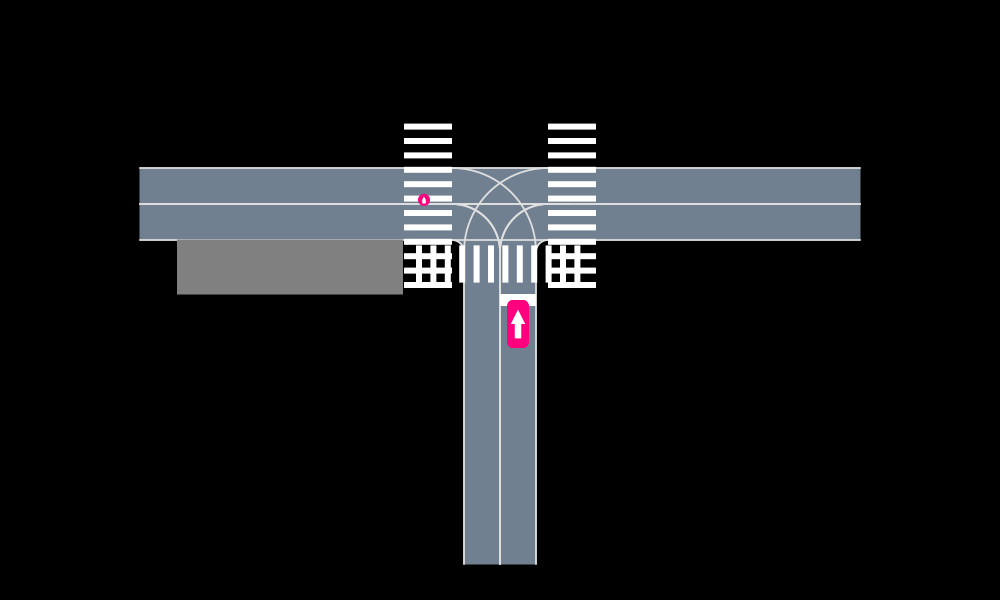

In [43]:
sc = most_likely_scene(pomdp, hist.belief_hist[2])
AutoViz.render(sc, pomdp.env, cam=cam)

In [16]:
struct MultipleInterpolatedBeliefsOverlay <: SceneOverlay
    beliefs::Dict{NTuple{3, Int64}, PedCarRNNBelief}
    pomdp::UrbanPOMDP
    mdp::PedCarMDP
    pedcar_pomdp::UrbanPOMDP
    models::Dict{Int64, DriverModel}
end

function AutoViz.render!(rendermodel::RenderModel, overlay::MultipleInterpolatedBeliefsOverlay , scene::Scene, env::OccludedEnv)
    for (ids, b) in overlay.beliefs 
        for j=1:length(b.predictions)
            obs = obs_to_scene(overlay.pedcar_pomdp, b.predictions[j])
            itp_overlay = InterpolationOverlay(overlay.mdp, overlay.models, obs, car_id=ids[1], ped_id=ids[2])
            render!(rendermodel, itp_overlay, scene, env)
        end
    end
end

In [ ]:
pedcar_beliefs = create_pedcar_beliefs(pomdp, b)
InterpolationOverlay(mdp, ai[end], obs_to_scene(pedcar_pomdp, ai[end-1][i].predictions[j])) for j=1:n_models for i in keys(ai[end-1])]...

In [12]:
methods(InterpolationOverlay)

# 2 methods for generic function "(::Type)":
[1] (::Type{InterpolationOverlay})(verbosity::Int64, color::Colorant, font_size::Int64, id::Int64, mdp::M, models::Dict{Int64,DriverModel}, ped_id::Int64, car_id::Int64, obs::Frame{Entity{VehicleState,VehicleDef,Int64}}) where M in Main at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/AutomotiveSafeRL/src/render_helpers.jl:227
[2] (::Type{InterpolationOverlay})(mdp::M, models::Dict{Int64,DriverModel}, obs::Frame{Entity{VehicleState,VehicleDef,Int64}}; id, verbosity, color, font_size, ped_id, car_id) where M<:Union{CarMDP, PedMDP, PedCarMDP} in Main at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/AutomotiveSafeRL/src/render_helpers.jl:246